In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=1.5)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\Professional\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k.

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=', ')
# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() #этот метод разделит датасет по колонкам как в массиве columns

df = df.replace('?', np.nan)

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x=='>50K')) # Будем предсказывать 1(True), если зарплата больше 50K, 0(False) иначе
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'educ-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'salary'],
      dtype='object')


In [4]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
numeric_data.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week
0,50,83311,13,0,0,13
1,38,215646,9,0,0,40
2,53,234721,7,0,0,40
3,28,338409,13,0,0,40
4,37,284582,14,0,0,40


In [5]:
df['education'].unique(), len(df['education'].unique())

(array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', '7th-8th', 'Doctorate', 'Assoc-voc', 'Prof-school',
        '5th-6th', '10th', 'Preschool', '12th', '1st-4th'], dtype=object), 16)

In [10]:
dummy_features = pd.get_dummies(categorial_data)

In [6]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X_origin = df.iloc[:, :-1]
X.head()

NameError: name 'dummy_features' is not defined

In [7]:
y = df['salary']

In [8]:
X.shape, X_origin.shape

NameError: name 'X' is not defined

Теперь всё готово для обучения алгоритмов.

In [9]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    train_size=0.8,
                                                    random_state=42)

Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. Используем идею кросс-валидации.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [10]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, 
                            param_grid=parameters,
                            cv=5, 
                            scoring='f1',
                            n_jobs=-1, 
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth']
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
param_scales = ['log', 'ordinary']

In [13]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

NameError: name 'X_train' is not defined

Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется. 
Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [24]:
max_trees = 100

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []
    
    X_train_kf = X_train[train_indices]
    y_train_kf = y_train[train_indices]
    
    X_val_kf = X_train[val_indices]
    y_val_kf = y_train[val_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))
    
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

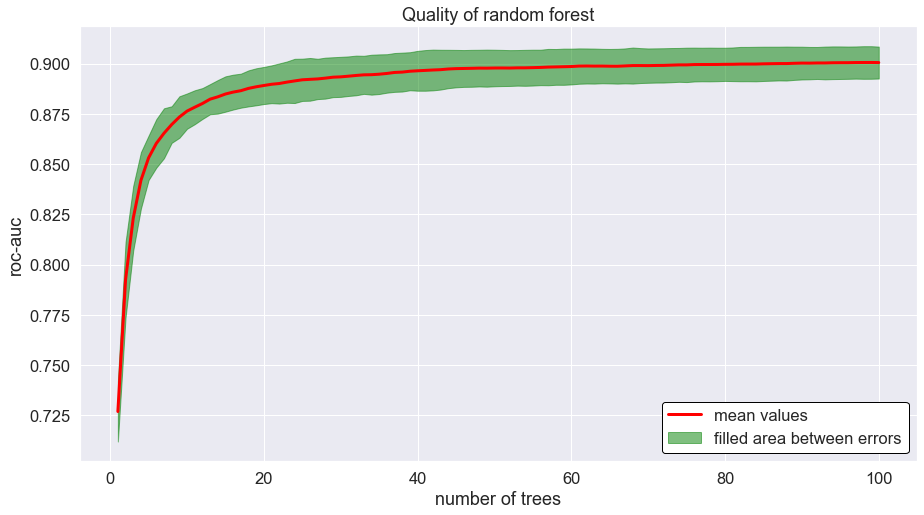

In [25]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values, 
                 mean_cross_val_score - 2 * std_cross_val_score, 
                 mean_cross_val_score + 2 * std_cross_val_score, 
                 color='green', 
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

### Нормировка признаков

Нормируем признаки и проделаем тот же эксперимент с алгоритмом ближайших соседей. Посмотрим, изменилось ли качество предсказания.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

`StandardScaler` выполняет преобразование $$z = \frac{x - \mu}{\sigma}, \text{где $\sigma$ - стандартное отклонение, а  $\mu$ - среднее}$$

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:  2.5min remaining:   50.9s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  3.1min remaining:   26.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.2min finished


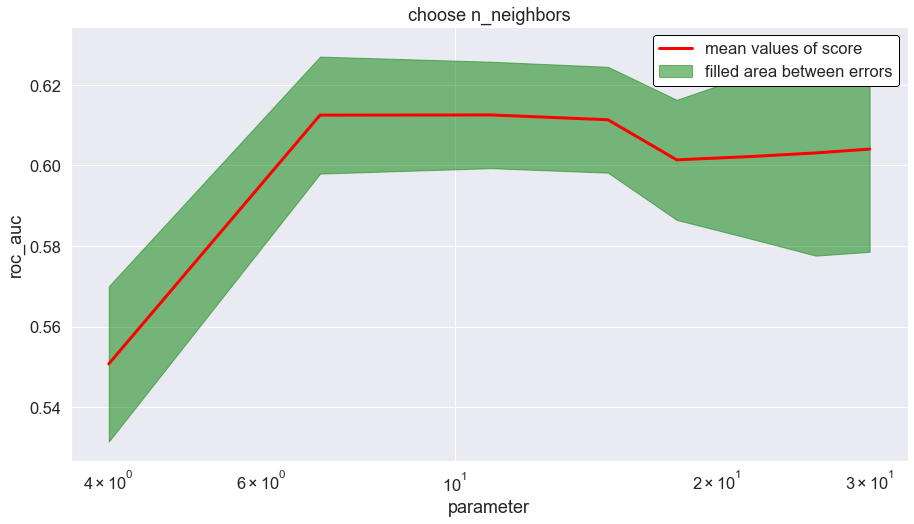

In [27]:
search_and_draw(X_train_scaled, y_train, KNeighborsClassifier(), 'n_neighbors', 
                np.array(np.linspace(4, 30, 8), dtype='int'), 'log');

Как и следовало ожидать, ни один из наших алгоритмов не побил случайный лес. Итак, видим, что на больших выборках бэггинг работает. Вычислим итоговое качество на test.

In [28]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

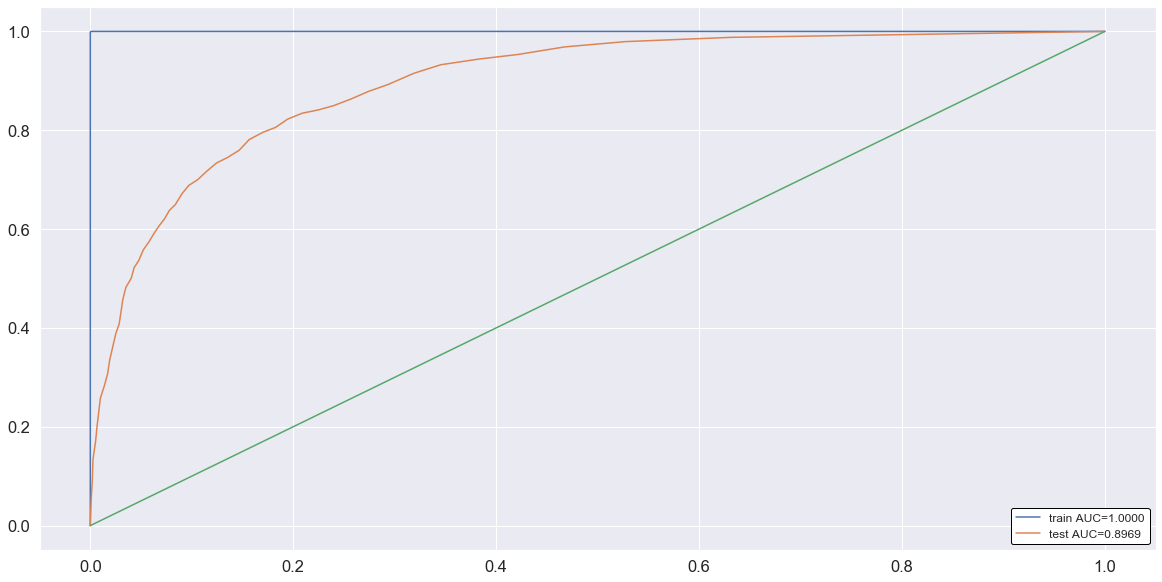

In [30]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [36]:
from sklearn.model_selection import cross_val_predict

Будем работать с тем же самым датасетом, что и ранее. Посмотрим, сумеем ли мы побить результаты случайного леса с помощью стекинга.

In [31]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [33]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [34]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

In [37]:
for model in tqdm(models):
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

In [38]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

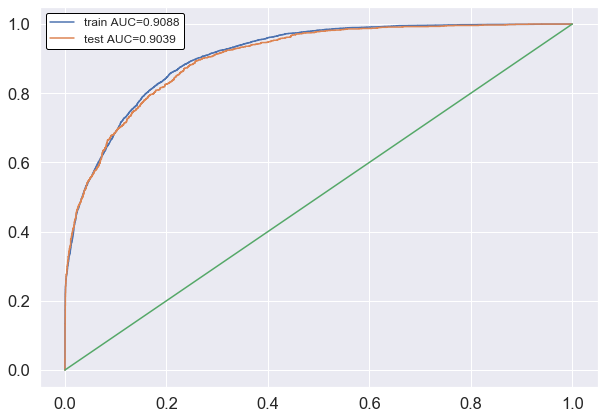

In [39]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

# Бустинг

Попробуем в пару-тройку строк побить всё то качество, которое мы так усердно искали.

In [41]:
# если этого модуля нет, то нужно раскомментировать следующую строчку и запустить
!pip install xgboost

In [42]:
import xgboost

In [43]:
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

[21:09:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


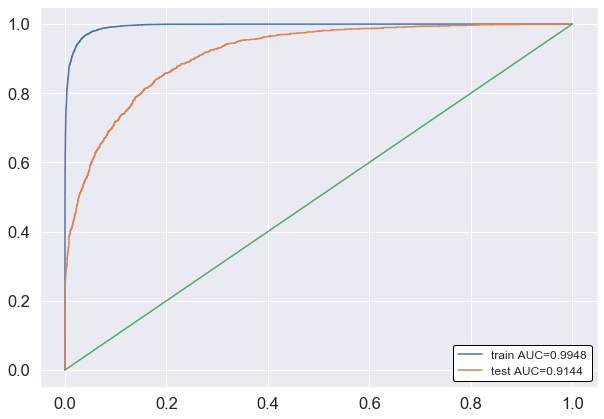

In [44]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Круто, да? А теперь попробуем "отечественного" производителя - CatBoost от Яндекса.

In [45]:
# если этого модуля нет, то нужно раскомментировать следующую строчку и запустить
!pip install catboost

  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11435 sha256=b42462aa2dff86c406e85be402dafeee32521793f1c8ac0644fabbe17ddd55de
  Stored in directory: C:\Users\Professional\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [46]:
import catboost # документация: https://catboost.ai/docs

In [47]:
# CatBoost умеет работать с категориальными признаками сам
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values, 
                                                       train_size=0.8, 
                                                       random_state=42)

In [48]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=categorical_indices)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

Learning rate set to 0.175479
0:	learn: 0.5372165	total: 101ms	remaining: 20.2s
1:	learn: 0.4526979	total: 143ms	remaining: 14.2s
2:	learn: 0.4081255	total: 184ms	remaining: 12.1s
3:	learn: 0.3778820	total: 224ms	remaining: 11s
4:	learn: 0.3566011	total: 265ms	remaining: 10.3s
5:	learn: 0.3455788	total: 304ms	remaining: 9.84s
6:	learn: 0.3350149	total: 346ms	remaining: 9.54s
7:	learn: 0.3268511	total: 388ms	remaining: 9.31s
8:	learn: 0.3229313	total: 429ms	remaining: 9.11s
9:	learn: 0.3186000	total: 470ms	remaining: 8.93s
10:	learn: 0.3160912	total: 508ms	remaining: 8.73s
11:	learn: 0.3135176	total: 548ms	remaining: 8.59s
12:	learn: 0.3106304	total: 591ms	remaining: 8.5s
13:	learn: 0.3088799	total: 631ms	remaining: 8.38s
14:	learn: 0.3069790	total: 674ms	remaining: 8.31s
15:	learn: 0.3054777	total: 717ms	remaining: 8.24s
16:	learn: 0.3045585	total: 761ms	remaining: 8.19s
17:	learn: 0.3026705	total: 802ms	remaining: 8.11s
18:	learn: 0.3018712	total: 844ms	remaining: 8.04s
19:	learn: 0.3

160:	learn: 0.2522822	total: 6.29s	remaining: 1.52s
161:	learn: 0.2521567	total: 6.33s	remaining: 1.48s
162:	learn: 0.2520546	total: 6.36s	remaining: 1.44s
163:	learn: 0.2518059	total: 6.4s	remaining: 1.41s
164:	learn: 0.2515874	total: 6.44s	remaining: 1.37s
165:	learn: 0.2514340	total: 6.48s	remaining: 1.33s
166:	learn: 0.2513762	total: 6.52s	remaining: 1.29s
167:	learn: 0.2512300	total: 6.56s	remaining: 1.25s
168:	learn: 0.2510750	total: 6.6s	remaining: 1.21s
169:	learn: 0.2509884	total: 6.63s	remaining: 1.17s
170:	learn: 0.2507551	total: 6.67s	remaining: 1.13s
171:	learn: 0.2507238	total: 6.71s	remaining: 1.09s
172:	learn: 0.2504978	total: 6.75s	remaining: 1.05s
173:	learn: 0.2503702	total: 6.79s	remaining: 1.01s
174:	learn: 0.2501651	total: 6.83s	remaining: 976ms
175:	learn: 0.2498019	total: 6.87s	remaining: 937ms
176:	learn: 0.2496528	total: 6.91s	remaining: 898ms
177:	learn: 0.2496287	total: 6.95s	remaining: 859ms
178:	learn: 0.2495429	total: 6.99s	remaining: 820ms
179:	learn: 0.

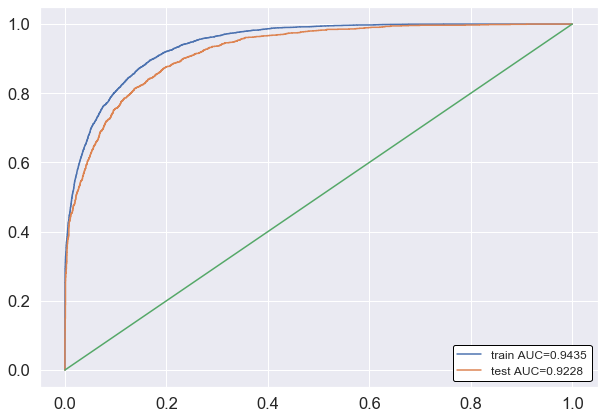

In [49]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [54]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, silent=True,
                                             cat_features=categorical_indices,
                                             eval_metric='AUC')
boosting_model.grid_search({'l2_leaf_reg': np.linspace(0, 1, 20)}, 
                           X_train_origin, 
                           y_train, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9190789019
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9190789	best: 0.9190789 (0)	total: 14.9s	remaining: 4m 43s

bestTest = 0.9201926181
bestIteration = 198

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.9201926	best: 0.9201926 (1)	total: 27.4s	remaining: 4m 6s


KeyboardInterrupt: 